# Learning a scheduler with Stable Baselines and PPO

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/renatolfc/sched-rl-gym/blob/master/docs/tutorials/ppo.ipynb)

In this tutorial we're going to use [sched-rl-gym](https://github.com/renatolfc/sched-rl-gym) to train an agent that's able to schedule jobs as discussed in the paper. If you want to follow along the tutorial, just click the "Open in Colab" badge above and you be redirected to an interactive notebook created just for you. 🤩

## Preliminaries

The first step is to install the environment with all its dependencies with the following command (some time in the future we'll add the project to the PyPI, making the command a lot smaller):

In [ ]:
%%capture

!git clone https://github.com/renatolfc/sched-rl-gym
!cd sched-rl-gym ; pip install -e '.[all]'
!ln -sf sched-rl-gym/schedgym

Now, in some initial versions of the environment, we used some `__future__` annotations that the Google Colab environment did not support. Therefore, we have to perform a cleanup before continuing.

This should not be necessary on Python >= 3.7...

In [ ]:
!find schedgym/ -type f -exec sed -i '/__future__/d' {} \;

Now we need to install [stable-baselines](https://stable-baselines.readthedocs.io/), which is going to allow us to train an agent:

In [ ]:
%%capture

!pip install tensorflow==1.15
!pip install stable-baselines

That's it for all dependencies. What we need now is to:
 * Import the environment so that it can be registered with [OpenAI Gym](https://gym.openai.com)
 * Import stable-baselines to learn our agent

We're also importing some other modules to interact with the filesystem and to help us compute some basic statistics...

In [ ]:
%%capture

import os
import gym
import numpy as np
import pandas as pd
import schedgym.envs as deeprm
import schedgym.envs.base as base

from stable_baselines import PPO2 as PPO
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import FeedForwardPolicy

We're going to define some variables to match those of the paper. They are:
 * `SLOTS`: The number of job slots to choose from (the number of actions - 1 the agent can perform)
 * `BACKLOG`: The number of jobs we represent outside the job slots (this should be a multiple of the `TIME_HORIZON`, defined below)
 * `TIME_LIMIT`: The number of RL time steps before finishing an episode
 * The default workload in the environment creates a new job with probability 0.7. The experiments in the paper were performed with probability 0.3. So we copy the default workload and define the new probability

In [ ]:
SLOTS: int = 10
BACKLOG: int = 60
TIME_LIMIT: int = 50
TIME_HORIZON: int = 20

workload = base.DEFAULT_WORKLOAD.copy()
workload['new_job_rate'] = .3

And since we're *not* using the default arguments, we're going to define a helper function to create new environments for us.

In [ ]:
def setup_environment(envname, workload=None) -> deeprm.DeepRmEnv:
    kwargs = {
        'job_slots': SLOTS,
        'time_limit': TIME_LIMIT,
        'backlog_size': BACKLOG,
        'time_horizon': TIME_HORIZON,
        'use_raw_state': False,
    }
    if workload is not None:
        kwargs['workload'] = workload
    env: deeprm.DeepRmEnv = gym.make(
        envname, **kwargs
    )
    env.reset()

    return env

Now, the default PPO implementation in stable baselines uses a two-layer MLP with 64 nodes each, but we're using 20 nodes, so we define a custom policy network to train our agent.

In the code below, `pi` corresponds to the policy network, while `vf` corresponds to the value function that is used as baseline function.

In [ ]:
class CustomPolicy(FeedForwardPolicy):
    def __init__(self, *args, **kwargs):
        super(CustomPolicy, self).__init__(*args, **kwargs,
                                           net_arch=[dict(pi=[20],
                                                          vf=[20])],
                                           feature_extraction="mlp")

With all that, we can instantiate our learner.

In [ ]:
env = setup_environment('DeepRM-v0', workload)
env = DummyVecEnv([lambda: env])
model = PPO(CustomPolicy, env, verbose=1,
            learning_rate=5e-4, ent_coef=0.01)

With all these definitions, we can now run our training loop.

The experiments in the paper ran for 1000 epochs, but that'd take too much time, so we're going to limit ourselves to a hundred.

You will notice that we define an epoch as 10000 time steps. This is equivalent to the number of interactions with the environment DeepRM counts as one epoch.

After each epoch, we save a snapshot of the model so that we can evaluate its performance. We should see ever improving, albeit noisy, performance.

In [ ]:
total_epochs = 250
timesteps_in_epoch = 1000
for i in range(total_epochs):
    print(f'\rRunning training epoch: {i}/{total_epochs}', end='')
    model.learn(total_timesteps=timesteps_in_epoch,
                reset_num_timesteps=(i == 0),
                log_interval=150)
    model.save(f'ppo_deeprm-{i}')

model.save('ppo_deeprm')

Running training epoch: 249/250

So now we have all intermediate sets of parameters. Nice!

How can we evaluate them? Well, since the environment is stochastic, we will have to use Monte Carlo to approximate the agent performance. So, let us assume we use 30 independent samples (we used 60 in the paper) and report the average performance, alongside the standard deviation.

We will also be (hard) limiting an episode to last for 200 time steps. In practice, they will terminate earlier due to the nature of our environment.

Before evaluating our environment, we need a few helper functions, as well as code for plotting. In the following cell, we import `matplotlib` to generate our graphs:

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('bmh')  # Bayesian Methods for Hackers

Now we define a function that, given a vector of rewards $\langle r_1, r_2, \ldots\rangle$, gives us a vector $\langle G_1=\sum_{i=1}^{T}\gamma^{i-1}r_i, G_2=\sum_{i=2}^{T}\gamma^{i-1}r_i, \ldots \rangle$, which will give us the sum of discounted rewards for all time steps encountered by the agent:

In [ ]:
def discount(x, gamma):
    """Returns discounted returns for all time steps in an episode.
    
    Given vector x, computes a vector y such that
    y[i] = x[i] + gamma * x[i+1] + gamma^2 x[i+2] + ...
    """
    out = np.zeros(len(x))
    out[-1] = x[-1]
    for i in reversed(list(range(len(x)-1))):
        out[i] = x[i] + gamma*out[i+1]
    return out

We also need the code that will instantiate the environment and evaluate the agent in such an environment. In this specific case, we gather a single trajectory, and compute the sum of rewards, the mean slowdown, the discounted sum of rewards for the first time step, and the mean reward for a single trajectory:

In [ ]:
def run_baselines_model(args):
    env, model, i, raw, workload = args
    env = setup_environment(env, workload=workload)
    env.use_raw_state = raw
    np.random.seed(i)
    rewards = []
    state = env.reset()
    for _ in range(200):
        action, _ = model.predict(state, deterministic=True)
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            break
    mean_slowdown = np.mean([
          1 + 1 / j.execution_time * (
              (j.start_time - j.submission_time)
              if j.start_time != -1
              else (env.scheduler.current_time - j.submission_time)
          )
          for j in env.scheduler.all_jobs
    ])
    return np.sum(rewards), mean_slowdown, discount(rewards, 0.99)[0],\
           np.mean(rewards)

Finally, with the two functions defined above, we can write code that evaluates the agent. In this particular case, the evaluation function takes a _class_ instance, an environment name, and a policy checkpoint file name template to evaluate an agent for `total_epochs` in a set of `runs` independent runs.

In [ ]:
from IPython.utils import io

def evaluate(model_class, env, template, runs=30, total_epochs=total_epochs):
  rewards, slowdowns, returns, means = [], [], [], []
  for i in range(total_epochs):
    print(f'\rEvaluating epoch {i}/{total_epochs}', end='')
    with io.capture_output():
      model = model_class.load(template.format(i))
    reward, slowdown, ret, mean = zip(
      *[run_baselines_model((env, model, j, False, workload))
        for j in range(runs)]
    )
    rewards.append(reward)
    slowdowns.append(slowdown)
    returns.append(ret)
    means.append(mean)
  return rewards, slowdowns, returns, means

Finally, with all the above definitions, we can run our agent and evaluate it with a single call to `evaluate`:

In [ ]:
rewards, slowdowns, returns, means = evaluate(
    PPO, 'DeepRM-v0', 'ppo_deeprm-{}', 60
)

Evaluating epoch 249/250

With everything executed, we can investigate how our agent fared in the evaluation runs.

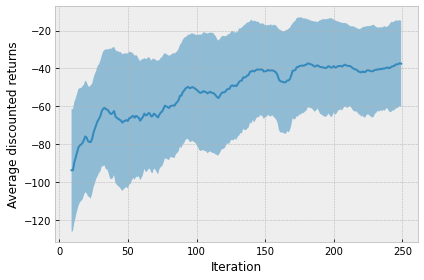

In [ ]:
df = pd.DataFrame({
  'mean': [np.mean(r) for r in returns],
  'std': [np.std(r) for r in returns]
})

fig, ax = plt.subplots()

y = df['mean'].rolling(window=10).mean()
yerror = df['std'].rolling(window=10).mean()
x = y.index

ax.plot(x, y)
ax.fill_between(x, y - yerror, y + yerror, alpha=.5)
ax.set_ylabel('Average discounted returns')
ax.set_xlabel('Iteration')
plt.tight_layout()
plt.show()

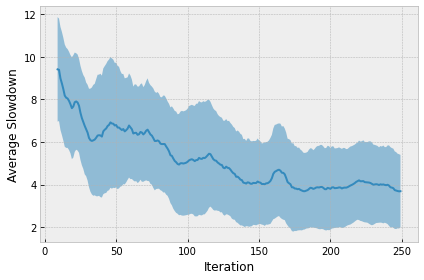

In [ ]:
df = pd.DataFrame({
  'mean': [np.mean(s) for s in slowdowns],
  'std': [np.std(s) for s in slowdowns]
})

fig, ax = plt.subplots()

y = df['mean'].rolling(window=10).mean()
yerror = df['std'].rolling(window=10).mean()
x = y.index

ax.plot(x, y)
ax.fill_between(x, y - yerror, y + yerror, alpha=.5)
ax.set_ylabel('Average Slowdown')
ax.set_xlabel('Iteration')
plt.tight_layout()
plt.show()